# Calculating Average Pipeline Duration with Salesforce Data

This tutorial walks through the concept of average pipeline duration. In order to make this work for your data you will need to substitute in several different features (anything specific to your organization or data) -- which I'll point out as you go.

Start in Salesforce reports. Go to New Report --> Opportunities -- > Opportunitiy History --> Create Report. Select All Opportunties for All Time. Add these fields: Created Date, Stage Change, and Stage Duration. Run the report, export the results to csv (you will probably need to Save As csv), and rename the file sfdata.csv. It's also probably easiest to open the csv file and manually delete the footer that salesforce automatically generates on all its reports.

In [79]:
# Load pandas, numpy, and ggplot libraries
import pandas as pd
import numpy as np
from ggplot import *
theme_bw() # sets the default  to the bw settings

# Additionally load matplot library to control graph display
%matplotlib inline
import matplotlib as mpl
gsize_timeseries = theme_matplotlib(rc={"figure.figsize": "12, 5"}, matplotlib_defaults=False)

In [44]:
# Load the data
data = pd.read_csv('sfdata.csv')

Inspecting the column headers in the data, should look like this:

In [45]:
print data.columns

Index([u'Deal Name', u'Owner', u'Closed', u'Created Date', u'Stage Change',
       u'From Stage', u'To Stage', u'Stage Duration', u'Last Modified',
       u'Square Footage', u'Amount'],
      dtype='object')


In [46]:
# Identify only the rows that tell us about a change in stage
data = data[data['Stage Change'] == 1]

Depending upon how homogenous your sales team is and the diversity of your products, you may want to focus only on a one segment. If not, skip this cell. I subset only our warehousing and distribution services and drop our transportation services -- since I am most interested in the former.

In [47]:
data = data[data['Owner'] != 'John Doe'] # this is specific to your analysis

For the next 2 steps, convert our dates to pandas date objects and create new columns that allow us to handle opportunties where the stage was changed multiple times in the same day. The reason for this -- if I sort a single opportunity by the Last Modified Date and assume that the most recent date is the current stage, that might not be true if multiple stage changes occured in the same day (due to the nature of our products, this is rare and as such, I don't track stage changes by time of day)

In [48]:
# Convert string dates into datetime objects
data['Created Date'] = pd.to_datetime(data['Created Date'])
data['Last Modified'] = pd.to_datetime(data['Last Modified'])

In [49]:
# In the event 2 stage changes are made on the same day... and one is backwards (from closed to proposal)
# This function and these fields will help us identify the current stage
# WARNING: My naming convention for stage names might be different than your naming convention for stage names
def label_stage(row, state):
    if row[state] == 'Exploratory':
        return 1
    if row[state] == 'Development':
        return 2
    if row[state] == 'Proposal':
        return 3
    if row[state] == 'Negotiation/Review':
        return 4
    if row[state] == 'Implementing':
        return 5
    if row[state] == 'Closed Won':
        return 6
    if row[state] == 'Closed Lost':
        return 6
    if row[state] == 'Business Not Awarded':
        return 6
    if row[state] == 'On Hold - Revisit':
        return 6

data['From Stage Label'] = data.apply(lambda row: label_stage(row, 'From Stage'),axis=1)
data['To Stage Label'] = data.apply(lambda row: label_stage(row, 'To Stage'),axis=1)
data['Stage Variance'] = data['To Stage Label'] - data['From Stage Label']

You'll need to create 2 lists -- a list of dates on which you'll want to calculate your average stage and average pipeline durations and a second list with all deal names.

In [51]:
from datetime import date, timedelta
# Start date can be the creation of the earliest opportunitiy
# The data was downloaded on April 9th 2016 -- so that should be the end date
min_date = data['Created Date'].min()
max_date = pd.to_datetime('20160409', format='%Y%m%d')
date_list = [min_date + timedelta(days=x) for x in range((max_date-min_date).days + 1)]

# Create list of accounts included in avwerage days metric
deals = data['Deal Name'].unique()

The for loop used to create the average pipeline duration for each day is quite long (and I'd love to get feedback on ways to imporve!) and for that reason I define some of the functionality beforehand. Below is function that will identify the current stage of a deal and assign the average days that deal has been in that stage to the appropriate list. Afterwards, I define a list that will identify close fields -- which will pass on opportunities that were already closed on a specific date.

In [52]:
# Create helper function to append average days to appropriate list
# WARNING: My naming convention for stage names might be different than your naming convention for stage names
def append_days(stage, days):
    if current_stage == 'Exploratory':
        exploratory_days.append(days)
    elif current_stage == 'Development':
        development_days.append(days)
    elif current_stage == 'Proposal':
        proposal_days.append(days)
    elif current_stage == 'Negotiation/Review':
        negotiation_days.append(days)
    elif current_stage == 'Implementing':
        implementation_days.append(days)
        
# when calculating the average pipeline duration, ignore closed deals if the deal was closed on specified date
# WARNING: My naming convention for closed deals might be different than your naming convention for closed deals
close_fields = ['Closed Lost', 'Closed Won', 'Business Not Awarded', 'On Hold - Revisit']

Let me explain what's happening in the nested for loop below -- it's pretty confusing. We are looping through every single day in the date list created above. For a single day -- for example 2/9/2016 -- we will loop through every opporutnity in our dataset above. For each opportuntiy we will identify whether it is active (active defined below) on 2/9/2016 and if so, what stage it is in. At that point we'll determine how many days it's been in that stage. We will take that number and append it to a temporary list (if the stage == 'Development', we'll put it in the Development list). Then, we'll move on to the next opportunity and repeat. Once we've looped through all opportunties we will have 5 lists as such:

Note: 'Active' deals are deals in Exploratory, Development, Proposal, Negotiaiton, or Implementation. For example, if an account is created on 3/1/2016 and we are running our loop for the date of 2/9/2016... the deal doesn't exist on this date and is therefore not 'active.' Likewise, if a deal was put into stage Closed - Won on 1/15/2016 and we are running our loop for the date 2/9/2016... the deal was closed prior to this date therefore the deal is not 'active.' 

We will take the average of these lists and create an an object where the key is the date and the value is a list of these averages. An example object will look like this:

At this point we'll move on to the next day -- 2/10/2016 -- and repeat the procedure. For every single day, we'll have an object that contains the average days in each stage for every opportunity in that stage on that day.

In [53]:
# create output
output = {}

for target_date in date_list:
    # each date in range will have seperate list of average day counts for each stage
    exploratory_days, development_days, proposal_days, negotiation_days, implementation_days = [], [], [], [], []
    
    for deal in deals:
        
        # subset only data for this deal
        deal_data = data[data['Deal Name'] == deal]
        
        # if the created date is after the target date -- skip bc this deal doesn't exist yet
        if deal_data['Created Date'].iloc[0] > target_date:
            continue
            
        # granted the deal existed at this target date, determine stage
        deal_data = deal_data.sort_values(by=['Last Modified', 'To Stage Label'], ascending=False)
        
        # loop through rows, if last mod date > target date then continue, otherwise that row is current stage
        for el in deal_data['Last Modified']:
            if el > target_date:
                continue
            else:
                current_date = el
                break
                
        # determine current stage
        current_stage = deal_data[deal_data['Last Modified'] == current_date]['To Stage']
        current_stage = current_stage.values[0]
        
        # if two stage changes occur on same date, find current stage
        if len(deal_data) > 1:
            if deal_data['Last Modified'].iloc[0] == deal_data['Last Modified'].iloc[1]:
                if -1 in deal_data['Stage Variance'].values:
                    current_stage = deal_data['To Stage'].iloc[1]
                    
        # if deal is already closed on this day, don't include
        if current_stage in close_fields:
            continue
            
        # otherwise add this to average days to appropriate list
        days = (target_date - current_date).days
       
        # append number of days to appropriate list
        append_days(current_stage, days)
    
    # calculate and store average of each stage list
    e = np.nanmean(exploratory_days)
    d = np.nanmean(development_days)
    p = np.nanmean(proposal_days)
    n = np.nanmean(negotiation_days)
    i = np.nanmean(implementation_days)
    
    # create output object where key is date and value is list of average stage durations
    average_days = [e, d, p, n, i]
    output[target_date] = average_days
    
    # this might take awhile depending upon date range so it's nice to see progress happening (but not necessary)
    # print 'added date: ' + str(target_date)

C:\Users\fcorrigan\AppData\Local\Continuum\Anaconda2\lib\site-packages\numpy\lib\nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Now that we have the data, the first thing I to do it put it in a pandas dataframe and relabel the column titles.

In [54]:
# Create dataframe and relabel columns
pdf = pd.DataFrame.from_dict(output, orient='index')
pdf.columns = ['Exploratory', 'Development', 'Proposal', 'Negotiation', 'Implementation']

The next step is clean up -- convert the dates to pandas date objects, fill the Nan cells with 0 (Nan would indicate that on that particular day, there were no opportunities in that particular stage), and create year and month variables.

In [55]:
# Sort by date and create datatime column
pdf = pdf.sort_index()
hold = pdf.index
pdf['date'] = hold
pdf.reset_index(drop=True)
pdf['date'] = pd.to_datetime(pdf['date'])

# Fill Nan with 0 days
pdf = pdf.fillna(0)

# Create a year and month variable
pdf['year'] = pdf.index.year
pdf['month'] = pdf.index.month

Create the average pipeline duration variable by summing each average stage duration by day.

In [56]:
# Create total variable and some subset variables
pdf['apd'] = pdf['Exploratory'] + pdf['Development'] + pdf['Proposal'] + pdf['Negotiation'] + pdf['Implementation']

If you're date range was large, you definitely don't want to run that loop the next time you fire up this ipython notebook. In that case, you may want to save the pdf to csv file and read it back in later. Otherwise, jump down to the next block...

In [57]:
# Read data into csv
pdf.to_csv('apd_salesforce_data.csv', index=False)

# When you come back and read data from csv into ipython
pdf = pd.read_csv("apd_salesforce_data.csv")
pdf['date'] = pd.to_datetime(pdf['date'])

At this point, you have the average pipeline duration data and are free to do whatever kind of exploration you deem necessary. You can start aggregating by month and year, graphing, and attempt to do some forecasting. You can compare these figures to win ratios, # of deals in the pipeline per day, or segmenting by stage type. To wrap up, I'll propose several useful aggregation ideas and graphs. 

In [75]:
pdf.tail()

Exploratory  Development   Proposal  Negotiation  Implementation  \
1889      139.125    30.000000  64.363636        36.60              37   
1890      140.125    31.000000  65.363636        37.60              38   
1891      141.125    31.642857  66.363636        38.60              39   
1892      142.125    28.083333  67.363636        28.75              45   
1893      143.125    29.083333  68.363636        29.75              46   

           date  year  month         apd  
1889 2016-04-05  2016      4  307.088636  
1890 2016-04-06  2016      4  312.088636  
1891 2016-04-07  2016      4  316.731494  
1892 2016-04-08  2016      4  311.321970  
1893 2016-04-09  2016      4  316.321970

In [58]:
# Make long dataframe so we can graph
data_long = pd.melt(pdf, id_vars=['date'])
data_long['value'] = data_long['value'].astype(int)

In [59]:
# I am hiding any depreciation warnings from pandas...
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Start by examining the distributions of average stage durations...

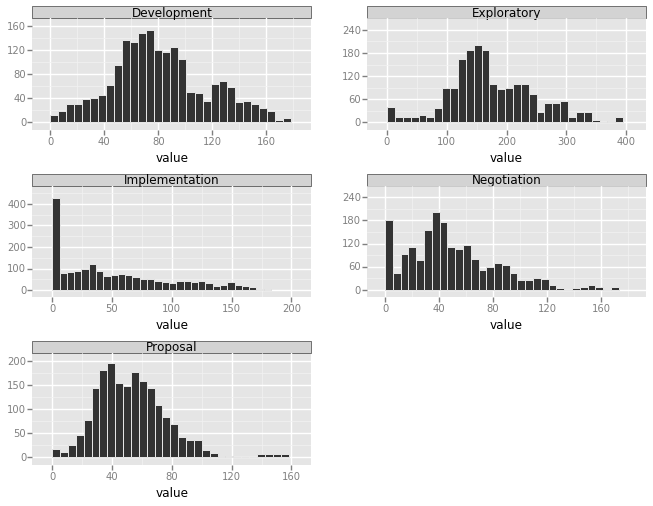

<ggplot: (38059114)>

In [60]:
# Inspect distribution for stages
stages = ['Exploratory', 'Development', 'Proposal', 'Negotiation', 'Implementation']
stages_data = data_long[data_long['variable'].isin(stages)]
ggplot(stages_data, aes(x='value')) + geom_histogram() + facet_wrap("variable")

To get a sense of what the average pipeline duration is for different periods we can subset different period...

In [61]:
# Calculating total average pipeline duration
total_duration = np.mean(pdf['apd'])
print 'Total duration = ' + str(total_duration) + ', and in months that = ' + str(total_duration/30)

Total duration = 412.558458346, and in months that = 13.7519486115


In [62]:
# Calculating 2016 average pipeline duration
twenty_sixteen = pdf[pdf['year'] == 2016]
td_2016 = np.mean(twenty_sixteen['apd'])
print 'Pipeline duration 2016 = ' + str(td_2016) + ', and in months that = ' + str(td_2016/30)

Pipeline duration 2016 = 285.329189435, and in months that = 9.51097298116


In [63]:
# Calculate April 9th, 2016 avearge pipeline duration
april9_apd_data = pdf[pdf['date'] == pd.to_datetime('20160409', format='%Y%m%d')]
april9_duration = np.mean(april9_apd_data['apd'])
print 'Pipeline duration for April 9th, 2016 in days = ' + str(april9_duration)
print 'Pipeline duration for April 9th, 2016 in months = ' + str(april9_duration/30)

Pipeline duration for April 9th, 2016 in days = 316.321969697
Pipeline duration for April 9th, 2016 in months = 10.5440656566


To get a broader sense of what average pipeline duration looks like we can create a time series chart and use a few different loess smoothing parameters...

<ggplot: (39318693)>


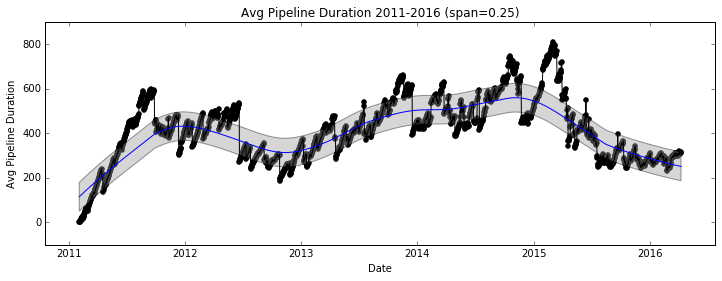

<ggplot: (40305742)>


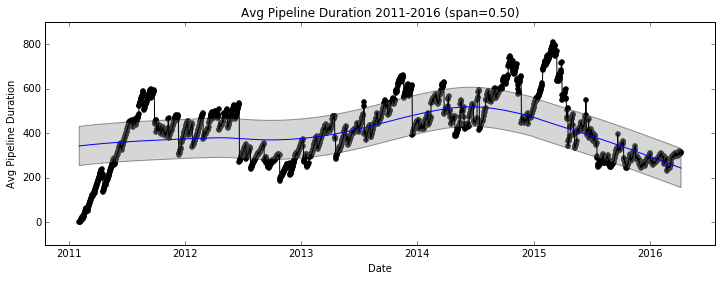

<ggplot: (39352773)>


In [64]:
# Inspect trend for average pipeline duration
print ggplot(pdf, aes(x='date', y='apd')) + geom_point() + geom_line() + geom_smooth(span=.15, color='blue', se=True) + \
    ggtitle('Avg Pipeline Duration 2011-2016 (span=0.15)') + xlab('Date') + ylab('Avg Pipeline Duration') + gsize_timeseries
print ggplot(pdf, aes(x='date', y='apd')) + geom_point() + geom_line() + geom_smooth(span=.25, color='blue', se=True) + \
    ggtitle('Avg Pipeline Duration 2011-2016 (span=0.25)') + xlab('Date') + ylab('Avg Pipeline Duration') + gsize_timeseries
print ggplot(pdf, aes(x='date', y='apd')) + geom_point() + geom_line() + geom_smooth(span=.50, color='blue', se=True) + \
    ggtitle('Avg Pipeline Duration 2011-2016 (span=0.50)') + xlab('Date') + ylab('Avg Pipeline Duration') + gsize_timeseries

And if I want to visualize what average pipeline duration looks like since the beginning of 2016 only...

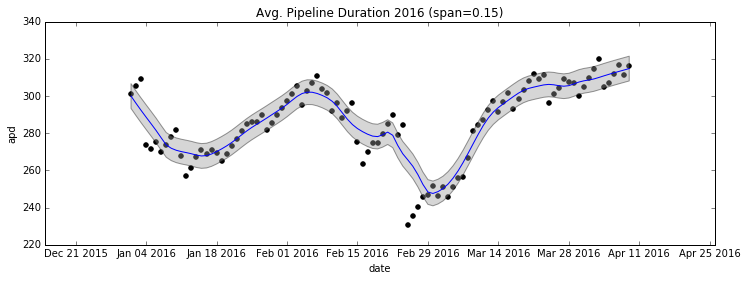

<ggplot: (40305864)>

In [65]:
# inspect trend for average of all stages (only in 2016)
twenty_sixteen = pdf[pdf['year'] == 2016]
ggplot(twenty_sixteen, aes(x='date', y='apd')) + geom_point() + geom_smooth(span=.15, color='blue', se=True) + \
    ggtitle('Avg. Pipeline Duration 2016 (span=0.15)') + gsize_timeseries

In [93]:
# inspect trend for average of each stage
stages = ['Exploratory', 'Development', 'Proposal', 'Negotiation', 'Implementation']
data_long_subset = data_long[data_long['variable'].isin(stages)]
ggplot(data_long_subset, aes(x='date', y='value', colour='variable')) + \
    geom_line() + ggtitle('Avg. Stage Duration 2011-2016 (span=0.15)') + \
    xlab('Date') + ylab('Avg. Stage Duration') + gsize_timeseries

<ggplot: (38059191)>

In [92]:
# inspect trend for average of each stage -- for only 2016
twenty_sixteen = pdf[pdf['year'] == 2016]
data_long_2 = pd.melt(twenty_sixteen, id_vars=['date'])
data_long_2['value'] = data_long_2['value'].astype(int)
stages = ['Exploratory', 'Development', 'Proposal', 'Negotiation', 'Implementation']
data_long_2s = data_long_2[data_long_2['variable'].isin(stages)]
ggplot(data_long_2s, aes(x='date', y='value', colour='variable')) + geom_point() + geom_line() + \
    geom_smooth(span=.15, color='blue', se=True) + ggtitle('Avg. Stage Duration 2016 (span=0.15)') + \
    xlab('Date') + ylab('Avg. Stage Duration') + gsize_timeseries

<ggplot: (42565808)>

Here are some of the things I saw and lightly concluded when I conducted this analysis on April 9th, 2016 with my own data. The average pipeline duration started coming down significantly in 2015 -- not surprising since the end of 2014 was sort of a new era for my company in the way it used and valued CRM data. Since the start of 2016, I've watched the duration creep up -- mainly in the Exploratory & Implementation stages, but also to a lesser extent in the Development & Proposal stages where I beleive I have the most influence as BDM. I understand and accept that this metric will be volatile depending upon peak season, time of year, and the diversity of opportunties. Afterall, from a 12-month run rate perspective... average pipeline duration is trending downward.

However, I am uncomfortable with the fact that our win ratio in the first 4 months of 2016 is significantly lower than for the same period in 2015 (measured by either deal count or deal size). I am uncomfortable with the fact that our team is working on more deals simultaneously on April 9th, 2016 than at any other time in the past 5 years with the same size team.

I beleive this is an opportuntity to more greatly utilize our CRM data and predictive analytics. A decent model to predict the probability of closing a new opportuntiy can direct our teams limited resources to the right opporutntiies simultaneoulsy reducing average pipeline duration and increasing win ration -- closing more deals faster. On top of that, tracking average pipeline duration with revenue growth will allow us to better forecast future revenue and capital requirements.